# Autoregressive HMMs

![](https://ars.els-cdn.com/content/image/1-s2.0-S0896627315010375-gr1.jpg)

In this lab we'll develop hidden Markov models, specifically Gaussian and autoregressive hidden Markov models, to analyze depth videos of freely behaving mice. We'll implement, from scratch, the model developed by Wiltschko et al (2015) and extended in Markowitz et al (2018). Figure 1 of Wiltschko et al is reproduced above.




**References**

Markowitz, J. E., Gillis, W. F., Beron, C. C., Neufeld, S. Q., Robertson, K., Bhagat, N. D., ... & Sabatini, B. L. (2018). The striatum organizes 3D behavior via moment-to-moment action selection. Cell, 174(1), 44-58.

Wiltschko, A. B., Johnson, M. J., Iurilli, G., Peterson, R. E., Katon, J. M., Pashkovski, S. L., ... & Datta, S. R. (2015). Mapping sub-second structure in mouse behavior. Neuron, 88(6), 1121-1135.




## Environment Setup

In [1]:
%%capture
!pip install pynwb
!pip install dynamax>=1.0.1

try:
    import jaxtyping
except ImportError:
    !pip install jaxtyping

In [2]:
# First, import necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange
from pynwb import NWBHDF5IO
from google.colab import files

from typing import List, Dict, Tuple, Optional, Any, Union, Sequence
from jaxtyping import Float, Int, UInt8

import torch
from torch.distributions import MultivariateNormal, Normal

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu')
dtype = torch.float32

Number = Union[int, float]

# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device=device, dtype=dtype)
from_t = lambda tensor: tensor.to("cpu").detach().numpy().astype(np.float64)

In [3]:
#@title Helper functions
import cv2
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import base64

sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "greyish",
                            "orange",
                            "amber",
                            "clay",
                            "pink"])


def combine(Ta: Number,
            a: Optional[Tuple[torch.Tensor, ...]],
            Tb: Number,
            b: Optional[Tuple[torch.Tensor, ...]]
            ) -> Tuple[Number, Optional[Tuple[torch.Tensor, ...]]]:
    """
    Combines two (optional) tuples of statistics, 'a' and 'b', weighted by Ta and Tb.

    If 'a' is None, the function returns (Tb, b). If 'b' is None, it returns (Ta, a).
    Otherwise, it computes a new tuple where each element is a weighted average
    of the corresponding elements in 'a' and 'b'. The weights Ta and Tb are used
    for elements from 'a' and 'b' respectively, and (Ta + Tb) serves as the
    denominator for the average.

    Args:
        Ta: The numerical weight for the first tuple of statistics 'a'.
        a: An optional tuple of torch.Tensors or similar numerical sequences.
        Tb: The numerical weight for the second tuple of statistics 'b'.
        b: An optional tuple of torch.Tensors or similar numerical sequences.

    Returns:
        The return structure varies:
        - If `a` is None: Returns a 2-tuple `(Tb, b)`, where `Tb` is the
          weight and `b` is the original sequence of statistics.
        - If `b` is None: Returns a 2-tuple `(Ta, a)`, where `Ta` is the
          weight and `a` is the original sequence of statistics.
        - If both `a` and `b` are provided: Returns a single tuple containing
          the element-wise weighted average of statistics from `a` and `b`.
          Note that in this specific case, unlike the others, a combined weight
          is not returned alongside the resulting sequence.

    Note:
        The function asserts that at least one of 'a' or 'b' must be truthy
        (i.e., not None and not empty if it's a sequence that Python evaluates as False when empty).
        It is assumed that if both 'a' and 'b' are provided:
        - They are sequences (e.g., tuples of torch.Tensors) of the same length
          for a meaningful element-wise combination. `zip` will truncate to the
          length of the shorter sequence if lengths differ.
        - The sum of weights (Ta + Tb) is non-zero to avoid division by zero errors.
    """
    assert a or b
    if a is None:
        return Tb, b
    elif b is None:
        return Ta, a
    else:
        return tuple((Ta * ai + Tb * bi) / (Ta + Tb) for ai, bi in zip(a, b))



_VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def _anim_to_html(anim: animation.Animation,
                  fps: int = 20) -> str:
    """
    Converts a matplotlib.animation.Animation object to an HTML video tag string.

    Saves the animation as a temporary MP4 file, encodes the video data in
    base64, and embeds it into an HTML <video> tag. Caches the base64 encoded
    video as an attribute `_encoded_video` on the `anim` object to avoid
    re-processing on subsequent calls.

    Args:
        anim: The matplotlib.animation.Animation object to convert.
        fps: Frames per second for the output MP4 video.

    Returns:
        An HTML string containing the <video> tag with the embedded animation.
    """
    # todo: todocument
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)

    return _VIDEO_TAG.format(anim._encoded_video.decode('ascii'))

def _display_animation(anim: animation.Animation,
                       fps: int = 30,
                       start: int = 0, # Currently unused
                       stop: int = None): # Currently unused
    """
    Displays a matplotlib.animation.Animation object as an HTML video.

    This function closes the original matplotlib figure associated with the
    animation and then renders the animation as an HTML5 video element,
    suitable for display in Jupyter notebooks or similar environments.

    Args:
        anim: The matplotlib.animation.Animation object to display.
        fps: Frames per second for the video playback.
        start: Start frame (parameter is present but currently unused by this function).
        stop: Stop frame (parameter is present but currently unused by this function).

    Returns:
        An IPython.display.HTML object that renders the animation as a video.
    """
    plt.close(anim._fig)
    return HTML(_anim_to_html(anim, fps=fps))

def play(movie: Union[np.ndarray, torch.Tensor],
         fps: int = 30,
         speedup: int = 1,
         fig_height: Number = 6,
         filename: Optional[str] = None,
         show_time: bool = False,
         show: bool = True
         ) -> Optional[HTML]:
    """
    Creates, displays, or saves an animation from a sequence of images.

    The animation is generated using matplotlib and can be shown directly
    in environments like Jupyter notebooks or saved to an MP4 file.

    Args:
        movie: A 3D (T,H,W) or 4D (T,H,W,C) NumPy array or PyTorch Tensor
               representing the video frames.
        fps: Frames per second for playback and for the saved video file.
        speedup: Factor to speed up playback (e.g., speedup=2 plays
                 every other frame).
        fig_height: Height of the matplotlib figure in inches. The width is
                    adjusted based on the movie's aspect ratio.
        filename: Optional. If provided, the animation is saved as an MP4
                  video to this path.
        show_time: If True, displays the current time (in seconds) overlaid
                   on the animation frames.
        show: If True, the animation is displayed as an HTML video in the
              output. If False, only saving (if `filename` is given) occurs.

    Returns:
        An IPython.display.HTML object containing the animation if 'show'
        is True and rendering is successful. Returns None otherwise (e.g.,
        if 'show' is False or an error occurs during HTML generation).
    """
    # First set up the figure, the axis, and the plot element we want to animate
    T, Py, Px = movie.shape[:3]
    fig, ax = plt.subplots(1, 1, figsize=(fig_height * Px/Py, fig_height))
    im = plt.imshow(movie[0], interpolation='None', cmap=plt.cm.gray)

    if show_time:
        tx = plt.text(0.75, 0.05, 't={:.3f}s'.format(0),
                    color='white',
                    fontdict=dict(size=12),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform=ax.transAxes)
    plt.axis('off')

    def animate(i):
        im.set_data(movie[i * speedup])
        if show_time:
            tx.set_text("t={:.3f}s".format(i * speedup / fps))
        return im,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate,
                                   frames=T // speedup,
                                   interval=1,
                                   blit=True)
    plt.close(anim._fig)

    # save to mp4 if filename specified
    if filename is not None:
        with open(filename, "wb") as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])

    # return an HTML video snippet
    if show:
        print("Preparing animation. This may take a minute...")
        return HTML(_anim_to_html(anim, fps=30))


def plot_data_and_states(
    data: Dict[str, Union[torch.Tensor, np.ndarray, Any]],
    states: Union[torch.Tensor, np.ndarray],
    spc: int = 4,
    slc: slice = slice(0, 900),
    title: Optional[str] = None
    ) -> None:
    """
    Plots principal component data along with discrete states over time.

    The function visualizes time-series data (e.g., principal components)
    as line plots. The discrete states, passed via the `states` argument,
    are shown as a background image. The `data` dictionary is also expected
    to contain a "labels" key, which is sliced and assigned to an internal
    variable, though its direct use in subsequent plotting commands within
    this snippet is not apparent; the `states` argument is used for the imshow background.

    Args:
        data (Dict[str, Union[torch.Tensor, np.ndarray, Any]]): A dictionary
            containing the data to plot. It must include:
            - "data": A 2D array-like (num_timesteps, num_features) of the
                      main data trajectories (e.g., principal components).
            - "times": A 1D array-like of timestamps corresponding to the data.
            - "labels": A 1D array-like of discrete labels. This is accessed
                        internally, though the primary state visualization uses
                        the `states` argument.
        states (Union[torch.Tensor, np.ndarray]): A 1D array-like of discrete
            states corresponding to each time step, used for the background
            visualization.
        spc (int, optional): Spacing factor for plotting multiple principal
            components vertically. Defaults to 4.
        slc (slice, optional): A slice object to select a portion of the
            data and states to plot. Defaults to slice(0, 900).
        title (Optional[str], optional): The title for the plot. If None,
            a default title "data and discrete states" is used.
            Defaults to None.

    Returns:
        None: The function generates and displays a plot using matplotlib.
    """
    times = data["times"][slc]
    labels = data["labels"][slc]
    x = data["data"][slc]
    num_timesteps, data_dim = x.shape

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(states[None, slc],
              cmap="cubehelix", aspect="auto",
              extent=(0, times[-1] - times[0], -data_dim * spc, spc))

    ax.plot(times - times[0],
            x - spc * np.arange(data_dim),
            ls='-', lw=3, color='w')
    ax.plot(times - times[0],
            x - spc * np.arange(data_dim),
            ls='-', lw=2, color=palette[0])

    ax.set_yticks(-spc * np.arange(data_dim))
    ax.set_yticklabels(np.arange(data_dim))
    ax.set_ylabel("principal component")
    ax.set_xlim(0, times[-1] - times[0])
    ax.set_xlabel("time [ms]")

    if title is None:
        ax.set_title("data and discrete states")
    else:
        ax.set_title(title)


def extract_syllable_slices(
    state_idx: Int[torch.Tensor, ""],
    posteriors: List[Dict[str, Float[torch.Tensor, "num_timesteps num_states"]]],
    pad: int = 30,
    num_instances: int = 50,
    min_duration: int = 5,
    max_duration: int = 45,
    seed: int = 0
    ) -> List[List[slice]]:
    """Extracts slices of data corresponding to occurrences of a specified state.

    This function identifies segments (syllables) where a given `state_idx`
    is the most probable state, based on posterior probabilities. It processes
    data for multiple "mice" (sessions), concatenates all found occurrences,
    filters them by duration and proximity to the start of the sequence (padding),
    and then selects a random subset of these occurrences. The final output is
    a list of lists, where the outer list corresponds to each mouse/session,
    and each inner list contains slice objects representing the selected
    syllable occurrences for that mouse.

    Args:
        state_idx: A scalar integer tensor representing the target state index
            for which to extract syllables.
        posteriors: A list of dictionaries, where each dictionary corresponds
            to a mouse/session. Each dictionary must contain the key
            "expected_states", which maps to a 2D tensor of shape
            (num_timesteps, num_states) representing the posterior probabilities
            of being in each state at each time step.
        pad: Minimum number of time steps from the beginning of a sequence
            for a syllable to be considered valid. Syllables starting before
            this padding are discarded. Defaults to 30.
        num_instances: The maximum number of syllable instances to randomly
            select across all mice after filtering. If fewer valid instances
            are found, all valid instances are returned. Defaults to 50.
        min_duration: The minimum duration (in time steps) for a syllable
            to be considered valid. Shorter syllables are discarded. Defaults to 5.
        max_duration: The maximum duration (in time steps) for a syllable
            to be considered valid. Longer syllables are discarded. Defaults to 45.
        seed: Seed for the random number generator used to select a subset
            of syllable instances. Defaults to 0.

    Returns:
        A list of lists of slice objects. The outer list has a length equal to
        the number of mice (i.e., `len(posteriors)`). Each inner list contains
        `slice(start_index, stop_index)` objects for the selected syllables
        of the corresponding mouse.
    """
    # Find all the start indices and durations of specified state
    state_idx = from_t(state_idx)
    all_mouse_inds = []
    all_starts = []
    all_durations = []
    for mouse, posterior in enumerate(posteriors):
        expected_states = from_t(posterior["expected_states"])
        states = np.argmax(expected_states, axis=1)
        states = np.concatenate([[-1], states, [-1]])
        starts = np.where((states[1:] == state_idx) \
                          & (states[:-1] != state_idx))[0]
        stops = np.where((states[:-1] == state_idx) \
                         & (states[1:] != state_idx))[0]
        durations = stops - starts
        assert np.all(durations >= 1)
        all_mouse_inds.append(mouse * np.ones(len(starts), dtype=int))
        all_starts.append(starts)
        all_durations.append(durations)

    all_mouse_inds = np.concatenate(all_mouse_inds)
    all_starts = np.concatenate(all_starts)
    all_durations = np.concatenate(all_durations)

    # Throw away ones that are too short or too close to start.
    # TODO: also throw away ones close to the end
    valid = (all_durations >= min_duration) \
            & (all_durations < max_duration) \
            & (all_starts > pad)

    num_valid = np.sum(valid)
    all_mouse_inds = all_mouse_inds[valid]
    all_starts = all_starts[valid]
    all_durations = all_durations[valid]

    # Choose a random subset to show
    rng = npr.RandomState(seed)
    subset = rng.choice(num_valid,
                        size=min(num_valid, num_instances),
                        replace=False)

    all_mouse_inds = all_mouse_inds[subset]
    all_starts = all_starts[subset]
    all_durations = all_durations[subset]

    # Extract slices for each mouse
    slices = []
    for mouse in range(len(posteriors)):
        is_mouse = (all_mouse_inds == mouse)
        slices.append([slice(start, start + dur) for start, dur in
                       zip(all_starts[is_mouse], all_durations[is_mouse])])

    return slices


def make_crowd_movie(
    state_idx: Int[torch.Tensor, ""],
    dataset: List[Dict[str, Union[UInt8[torch.Tensor, "num_dataset_frames frame_height frame_width"], Float[torch.Tensor, "num_dataset_frames"]]]],
    posteriors: List[Dict[str, Float[torch.Tensor, "num_timesteps num_states"]]],
    pad: int = 30,
    raw_size: Tuple[int, int] = (512, 424),
    crop_size: Tuple[int, int] = (80, 80),
    offset: Tuple[int, int] = (50, 50),
    scale: float = 0.5,
    min_height: int = 10,
    **kwargs: Any
    ) -> Optional[UInt8[np.ndarray, "output_num_frames canvas_height canvas_width 3"]]:
    """
    Creates a "crowd movie" by superimposing video clips of a specific behavioral state.

    This function first extracts time slices (syllables) corresponding to a given
    `state_idx` using the `extract_syllable_slices` function. For each of these
    syllables, it takes the corresponding video frames from the `dataset`,
    processes them (rotation, scaling), and overlays them onto a larger canvas
    to create a movie where multiple instances of the behavior play simultaneously.

    Args:
        state_idx: A scalar integer tensor representing the target state index
            for which to create the crowd movie.
        dataset: A list of dictionaries, where each dictionary corresponds to a
            data session (e.g., a mouse). Each dictionary must contain:
            - 'frames': A 3D tensor (num_frames, height, width) of uint8 video frames.
            - 'centroid_x_px': A 1D float tensor of x-coordinates for the centroid.
            - 'centroid_y_px': A 1D float tensor of y-coordinates for the centroid.
            - 'angles': A 1D float tensor of orientation angles.
        posteriors: A list of dictionaries, passed to `extract_syllable_slices`.
            Each dictionary corresponds to a session and must contain
            "expected_states": a 2D tensor (num_timesteps, num_states) of
            posterior probabilities.
        pad: Integer, number of padding frames to add before and after each
            syllable clip in the output movie. This `pad` also influences the
            total duration of the output movie. Note that `extract_syllable_slices`
            might use its own `pad` parameter (potentially passed via `**kwargs`)
            for syllable selection.
        raw_size: Tuple (canvas_width, canvas_height) defining the dimensions
            of the output movie canvas. Defaults to (512, 424).
        crop_size: Tuple (crop_width, crop_height) defining the size to which
            individual mouse frames are warped and cropped. This also determines
            the reference for rotation centers `xc0, yc0`. Defaults to (80, 80).
        offset: Tuple (offset_x, offset_y) added to centroid coordinates for
            positioning the cropped frames on the canvas. Defaults to (50, 50).
        scale: Float, scaling factor applied to frame pixel values during processing.
            Defaults to 0.5.
        min_height: Integer, a threshold for pixel values. Pixels below this
            height in processed frames are zeroed out before blending.
            Defaults to 10.
        **kwargs: Additional keyword arguments passed directly to the
            `extract_syllable_slices` function. This can include arguments like
            `pad` (for syllable selection), `num_instances`, `min_duration`,
            `max_duration`, and `seed`.

    Returns:
        An optional 4D numpy array (num_frames, height, width, channels=3) of
        dtype uint8, representing the generated crowd movie. Returns `None` if
        no valid syllables are found for the given `state_idx`.
    """
    slices = extract_syllable_slices(state_idx, posteriors)

    xc0, yc0 = crop_size[1] // 2, crop_size[0] // 2
    xc = np.arange(-xc0, xc0 + 1, dtype='int16')
    yc = np.arange(-yc0, yc0 + 1, dtype='int16')

    durs = []
    for these_slices in slices:
        for slc in these_slices:
            durs.append(slc.stop - slc.start)

    if len(durs) == 0:
        print("no valid syllables found for state", state_idx)
        return
    max_dur = np.max(durs)

    # Initialize the crowd movie
    crowd_movie = np.zeros((max_dur + pad * 2, raw_size[1], raw_size[0], 3),
                            dtype='uint8')

    for these_slices, data in zip(slices, dataset):
        for slc in these_slices:
            lpad = min(pad, slc.start)
            rpad = min(pad, len(data['frames']) - slc.stop)
            dur = slc.stop - slc.start
            padded_slc = slice(slc.start - lpad, slc.stop + rpad)
            centroid_x = from_t(data['centroid_x_px'][padded_slc] + offset[0])
            centroid_y = from_t(data['centroid_y_px'][padded_slc] + offset[1])
            angles = np.rad2deg(from_t(data['angles'][padded_slc]))
            frames = data['frames'].detach().numpy()
            frames = (frames[padded_slc] / scale).astype('uint8')
            flips = np.zeros(angles.shape, dtype='bool')

            for i in range(lpad + dur + rpad):
                if np.any(np.isnan([centroid_x[i], centroid_y[i]])):
                    continue

                rr = (yc + centroid_y[i]).astype('int16')
                cc = (xc + centroid_x[i]).astype('int16')

                if (np.any(rr < 1)
                    or np.any(cc < 1)
                    or np.any(rr >= raw_size[1])
                    or np.any(cc >= raw_size[0])
                    or (rr[-1] - rr[0] != crop_size[0])
                    or (cc[-1] - cc[0] != crop_size[1])):
                    continue

                # rotate and clip the current frame
                new_frame_clip = frames[i][:, :, None] * np.ones((1, 1, 3))
                rot_mat = cv2.getRotationMatrix2D((xc0, yc0), angles[i], 1)
                new_frame_clip = cv2.warpAffine(new_frame_clip.astype('float32'),
                                                rot_mat, crop_size).astype(frames.dtype)

                # overlay a circle on the mouse
                if i >= lpad and i <= pad + dur:
                    cv2.circle(new_frame_clip, (xc0, yc0), 3,
                               (255, 0, 0), -1)

                # superimpose the clipped mouse
                old_frame = crowd_movie[i]
                new_frame = np.zeros_like(old_frame)
                new_frame[rr[0]:rr[-1], cc[0]:cc[-1]] = new_frame_clip

                # zero out based on min_height before taking the non-zeros
                new_frame[new_frame < min_height] = 0
                old_frame[old_frame < min_height] = 0

                new_frame_nz = new_frame > 0
                old_frame_nz = old_frame > 0

                blend_coords = np.logical_and(new_frame_nz, old_frame_nz)
                overwrite_coords = np.logical_and(new_frame_nz, ~old_frame_nz)

                old_frame[blend_coords] = .5 * old_frame[blend_coords] \
                    + .5 * new_frame[blend_coords]
                old_frame[overwrite_coords] = new_frame[overwrite_coords]

                crowd_movie[i] = old_frame

    return crowd_movie

def plot_average_pcs(
    state_idx: Union[int, Int[torch.Tensor, ""]], # Can be int or scalar Tensor
    dataset: List[Dict[str, Union[Float[torch.Tensor, "Any num_features"], Float[np.ndarray, "Any num_features"]]]],
    posteriors: List[Dict[str, Float[torch.Tensor, "num_timesteps num_states"]]],
    spc: int = 4,
    pad: int = 30
    ) -> None:
    """
    Plots the average Principal Component (PC) trajectories time-locked to a specific state.

    This function first extracts occurrences (syllables) of the specified `state_idx`
    using `extract_syllable_slices`. It then aligns these occurrences and calculates
    the mean and standard deviation of the PC trajectories around the onset of the state.
    The resulting average PCs are plotted, with shaded areas indicating +/- 2 standard
    deviations. A vertical red line marks the state onset (t=0).

    This function relies on globally defined `fps` (frames per second) and
    `data_dim` (number of PC features to plot).

    Args:
        state_idx: The state index for which to plot the average PCs. Can be an
            integer or a scalar integer PyTorch Tensor.
        dataset: A list of dictionaries, where each dictionary corresponds to a data
            session (e.g., a mouse). Each dictionary must contain the key 'data',
            mapping to a 2D Tensor or numpy array of shape (num_timesteps, num_features)
            containing the PC time series. `num_features` should match global `data_dim`.
        posteriors: A list of dictionaries, passed to `extract_syllable_slices`.
            Each dictionary corresponds to a session and must contain
            "expected_states": a 2D tensor (num_timesteps, num_states) of
            posterior probabilities.
        spc: Vertical spacing factor for plotting multiple PC traces.
            Defaults to 4.
        pad: Padding (in time steps) around each extracted syllable, used for
            defining the time window for averaging and plotting. Also passed to
            `extract_syllable_slices` for its `pad` argument during slice extraction.
            Defaults to 30.

    Returns:
        None. The function generates and displays a plot using matplotlib.
              It prints a message and returns if no valid syllables are found.
    """
    # Find slices for this state
    slices = extract_syllable_slices(state_idx, posteriors, num_instances=1000)
    data_dim = dataset[0]['data'].shape[1]

    # Find maximum duration
    durs = []
    num_slices = 0
    for these_slices in slices:
        for slc in these_slices:
            durs.append(slc.stop - slc.start)
            num_slices += 1
    if num_slices == 0:
        print("no valid syllables found for state", state_idx)
        return
    max_dur = np.max(durs)

    # Initialize timestamps
    times = np.arange(-pad, max_dur + pad) / fps
    exs = np.nan * np.ones((num_slices, 2 * pad + max_dur, data_dim))
    counter = 0

    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for these_slices, data, posterior in zip(slices, dataset, posteriors):
        for slc in these_slices:
            lpad = min(pad, slc.start)
            rpad = min(pad, len(data['data']) - slc.stop)
            dur = slc.stop - slc.start
            padded_slc = slice(slc.start - lpad, slc.stop + rpad)

            x = data['data'][padded_slc]
            exs[counter][(pad - lpad):(pad - lpad + len(x))] = x
            counter += 1

            # Plot single example
            # ax.plot(times[(pad - lpad):(pad - lpad + len(x))],
            #         x - spc * np.arange(data_dim),
            #         ls='-', lw=.5, color='k')

    # take the mean and standard deviation
    ex_mean = np.nanmean(exs, axis=0)
    ex_std = np.nanstd(exs, axis=0)

    for d in range(data_dim):
        ax.fill_between(times,
                        ex_mean[:, d] - 2 * ex_std[:, d] - spc * d,
                        ex_mean[:, d] + 2 * ex_std[:, d] - spc * d,
                        color='k', alpha=0.25)

        ax.plot(times, ex_mean[:, d] - spc * d, '-k', lw=2)

    ax.plot([0, 0], [-spc * data_dim, spc], '-r', lw=2)
    ax.set_yticks(-spc * np.arange(data_dim))
    ax.set_yticklabels(np.arange(data_dim))
    ax.set_ylim(-spc * data_dim, spc)
    ax.set_ylabel("principal component")
    ax.set_xlim(times[0], times[-1])
    ax.set_xlabel("$\Delta t$ [ms]")

    ax.set_title("Average PCs for State {}".format(state_idx))

### Load the data

Fetch a single nwb file from the dropbox repo. These nwb files contain all relevant data from a specific moseq session.

In [4]:
%%capture
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/06_arhmm/moseq_data.zip
!unzip -n moseq_data.zip

## Warm up: Intro to the Neurodata Without Borders (NWB) format

_This section was prepared by Akshay Jaggi (Datta Lab)_

NWBs are hdf5 files with added structure. Like hdf5 files, they are hierarchically organized into Groups and Datasets. However, unlike hdf5 files, NWBs have rigid organization and labeling of these Groups and Datasets to ensure consistency across labs.

The highest level of organization in NWBs are acquisitions and processing modules. Acquisitions are raw data streams (or links to them), and processing modules are groups of analyzed data derived from the acquisitions.

MoSeq acquisitions are noisy, complex kinect videos that are then processed into egocentrically aligned, cleaned frames that you'll be working with. Since you don't need to worry about those preprocessing steps, the acquisition folder is empty. All of you relevant data will be in the MoSeq processing module.

Inside processing modules, you'll find "BehavioralTimeSeries," which are collections of related behavioral time series. Inside these objects, you'll find "TimeSeries," which are individual time series datasets.

The processing module is organized as such:
```
 - MoSeq Processing Module (top level for all MoSeq processed data)
   - MoSeq Scalar Time Series (Behavioral time series dictionary for all MoSeq derived scalar time series)
     - angle
     - area
     - etc.
   - MoSeq Image Series (Behavioral time series dictionary for all MoSeq derived image time series)
     - frames
     - masks
   - MoSeq PC Series (Behavioral time series dictionary for all MoSeq derived PC time series)
     - principal components (with nans inserted for dropped frames)
     - principal components cleaned (with no nans)
   - MoSeq Label Series (Behavioral time series dictionary for all MoSeq derived lables)
     - labels (see above about dropped frames)
     - labels cleaned (see above)
```

### Read in an NWB file

In [5]:
nwb_path = 'saline_example_0.nwb'
io = NWBHDF5IO(nwb_path, mode='r')
nwbfile = io.read()

/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [6]:
# Print the contents of the processing module
nwbfile.processing['MoSeq']

Data type,uint8
Shape,"(35964, 80, 80)"
Array size,219.51 MiB
Chunk shape,"(2248, 5, 10)"
Compression,gzip
Compression opts,4
Compression ratio,17.474722459138142
Data type,float64
Shape,"(35964,)"
Array size,280.97 KiB
Chunk shape,None


In [7]:
# Print the contents of one BehavioralTimeSeries
nwbfile.processing['MoSeq']['Images']

Data type,uint8
Shape,"(35964, 80, 80)"
Array size,219.51 MiB
Chunk shape,"(2248, 5, 10)"
Compression,gzip
Compression opts,4
Compression ratio,17.474722459138142
Data type,float64
Shape,"(35964,)"
Array size,280.97 KiB
Chunk shape,None


In [8]:
# Examine the 'frames' time series
# One thing you'll notice is that the "timestamps" is actually another time series
# This is to save storage space when many time series share the same time stamps
nwbfile.processing['MoSeq']['Images']['frames']

Data type,uint8
Shape,"(35964, 80, 80)"
Array size,219.51 MiB
Chunk shape,"(2248, 5, 10)"
Compression,gzip
Compression opts,4
Compression ratio,17.474722459138142
Data type,float64
Shape,"(35964,)"
Array size,280.97 KiB
Chunk shape,None


### Load the video frames



In [9]:
# Since NWBs are backed with HDF5, you can do typical lazy/partial loading here
# Like hdf5s, you'll need to slice with [:] to get the array.
frames = nwbfile.processing['MoSeq']['Images']['frames'].data[:]

# Make sure to close the file when you're done!
io.close()

# Play a movie of the first 30 sec of data
play(frames[:900])

Preparing animation. This may take a minute...


### Now we'll load all the mice into memory

The frames, even after cropping, are still 80x80 pixels. That's a 3600 dimensional observation. In practice, the frames can be adequately reconstructed with far fewer principal components. As little as ten PCs does a pretty good job of capturing the mouse's posture.

The Datta lab has already computed the principal components and included them in the NWB. We'll extract them, along with other relevant information like the centroid position and heading angle of the mouse, which we'll use for making "crowd" movies below. Finally, they also included labels from MoSeq, an autoregressive (AR) HMM. You'll build an ARHMM in Part 3 of the lab and infer similar discrete latent state sequences yourself!

In [10]:
def load_dataset(
    indices: Optional[Union[np.ndarray, Sequence[int]]] = None,
    load_frames: bool = True,
    num_pcs: int = 10
    ) -> Tuple[
    List[Dict[str, Union[Float[torch.Tensor, "num_train_frames num_pcs_loaded"],
                         Float[torch.Tensor, "num_train_frames"]]]],
    List[Dict[str, Union[Float[torch.Tensor, "num_test_frames num_pcs_loaded"],
                         Float[torch.Tensor, "num_test_frames"],
                         UInt8[torch.Tensor, "num_test_frames frame_height frame_width"]]]]
    ]:
    """
    Loads and processes mouse behavioral data from a series of NWB files.

    For each NWB file specified by `indices`, this function reads various
    time series data (principal components, timestamps, centroids, angles, labels),
    splits it into training (first 80%) and testing (remaining ~20%) segments,
    and converts the data into PyTorch tensors. Raw video frames can also be
    loaded for the test set.

    Args:
        indices: A sequence or NumPy array of integer indices specifying which
            NWB files to load (e.g., `saline_example_{index}.nwb`).
            If None, defaults to `np.arange(24)`, loading files 0 through 23.
        load_frames: If True, loads the raw video frames for the test dataset
            segments. Defaults to True.
        num_pcs: The number of principal components to extract from the
            'pcs_clean' dataset in the NWB files. Defaults to 10.

    Returns:
        A tuple `(train_dataset, test_dataset)`:
        - `train_dataset`: A list of dictionaries. Each dictionary contains
          data for one training segment from an NWB file, with keys:
            - "raw_pcs": Tensor (num_train_frames, `num_pcs`) of principal components.
            - "times": Tensor (num_train_frames,) of timestamps.
            - "centroid_x_px": Tensor (num_train_frames,) of x-centroids.
            - "centroid_y_px": Tensor (num_train_frames,) of y-centroids.
            - "angles": Tensor (num_train_frames,) of head angles.
            - "labels": Tensor (num_train_frames,) of behavioral labels.
              (Note: converted to float32 by the `to_t` helper).
        - `test_dataset`: A list of dictionaries, similar structure to
          `train_dataset` but for testing segments. If `load_frames` is True,
          each dictionary will also contain:
            - "frames": Tensor (num_test_frames, frame_height, frame_width)
              of uint8 video frames.
          (Note: `num_train_frames` and `num_test_frames` can vary per file.
           `num_pcs_loaded` will match the `num_pcs` argument. `frame_height`
           and `frame_width` are inherent to the video data.)
    """
    if indices is None:
        indices = np.arange(24)

    train_dataset = []
    test_dataset = []
    for t in trange(len(indices)):
        i = indices[t]
        nwb_path = "saline_example_{}.nwb".format(i)
        with NWBHDF5IO(nwb_path, mode='r') as io:
            f = io.read()
            num_frames = len(f.processing['MoSeq']['PCs']['pcs_clean'].data)
            train_slc = slice(0, int(0.8 * num_frames))
            test_slc = slice(int(0.8 * num_frames)+1, -1)

            train_data, test_data = dict(), dict()
            for slc, data in zip([train_slc, test_slc], [train_data, test_data]):
                data["raw_pcs"] = to_t(f.processing['MoSeq']['PCs']['pcs_clean'].data[slc][:, :num_pcs])
                data["times"] = to_t(f.processing['MoSeq']['PCs']['pcs_clean'].timestamps[slc][:])
                data["centroid_x_px"] = to_t(f.processing['MoSeq']['Scalars']['centroid_x_px'].data[slc][:])
                data["centroid_y_px"] = to_t(f.processing['MoSeq']['Scalars']['centroid_y_px'].data[slc][:])
                data["angles"] = to_t(f.processing['MoSeq']['Scalars']['angle'].data[slc][:])
                data["labels"] = to_t(f.processing['MoSeq']['Labels']['labels_clean'].data[slc][:])

            # only load the frames on the test data
            # test_data["frames"] = to_t(f.processing['MoSeq']['Images']['frames'].data[test_slc])
            test_data["frames"] = torch.tensor(f.processing['MoSeq']['Images']['frames'].data[test_slc])

        train_dataset.append(train_data)
        test_dataset.append(test_data)

    return train_dataset, test_dataset

# Load a third of the dataset (8 mice)
fps = 30
data_dim = 10
indices = np.arange(8)
train_dataset, test_dataset = load_dataset(num_pcs=data_dim, indices=indices)

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Load the data

In [11]:
# Play a movie of the first 30 sec of data
frames = test_dataset[0]['frames']
play(test_dataset[0]['frames'][:900])

Preparing animation. This may take a minute...


###  Standardize the principal components

Standardize the principal components so that they are
mean zero and unit variance. This will not affect the
subsequent modeling, but it will make it easier for us
to visualize the time series.

In [12]:
def standardize_pcs(
    dataset: List[Dict[str, Any]],
    mean: Optional[Float[torch.Tensor, "num_pcs"]] = None,
    std: Optional[Float[torch.Tensor, "num_pcs"]] = None
    ) -> Tuple[
    List[Dict[str, Any]],
    Float[torch.Tensor, "num_pcs"],
    Float[torch.Tensor, "num_pcs"]
    ]:
    """Standardizes 'raw_pcs' in each item of `dataset` (to mean=0, std=1).

    If `mean` and `std` are None, they are computed from all 'raw_pcs'
    tensors in `dataset`. A 'data' key with the standardized PCs is added
    to each dictionary in `dataset` (in-place modification).

    Args:
        dataset: List of dicts, each must contain a 'raw_pcs' PyTorch Tensor.
                 The list and its dictionaries are modified in-place.
        mean: Optional 1D PyTorch Tensor of means for each PC.
        std: Optional 1D PyTorch Tensor of standard deviations for each PC.

    Returns:
        Tuple: (`dataset`, `mean`, `std`), where `dataset` is the modified
        list of dicts, and `mean`/`std` are the 1D Tensors used.
    """
    if mean is None and std is None:
        all_pcs = torch.vstack([data['raw_pcs'] for data in dataset])
        mean = all_pcs.mean(axis=0)
        std = all_pcs.std(axis=0)

    for data in dataset:
        data['data'] = (data['raw_pcs'] - mean) / std
    return dataset, mean, std

train_dataset, mean, std = standardize_pcs(train_dataset)
test_dataset, _, _ = standardize_pcs(test_dataset, mean, std)

### Plot a slice of data
In the background, we're showing the labels that were given to us from MoSeq, an autoregressive hidden Markov model.

<ipython-input-3-6a185389def7>:249: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x - spc * np.arange(data_dim),
<ipython-input-3-6a185389def7>:252: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x - spc * np.arange(data_dim),


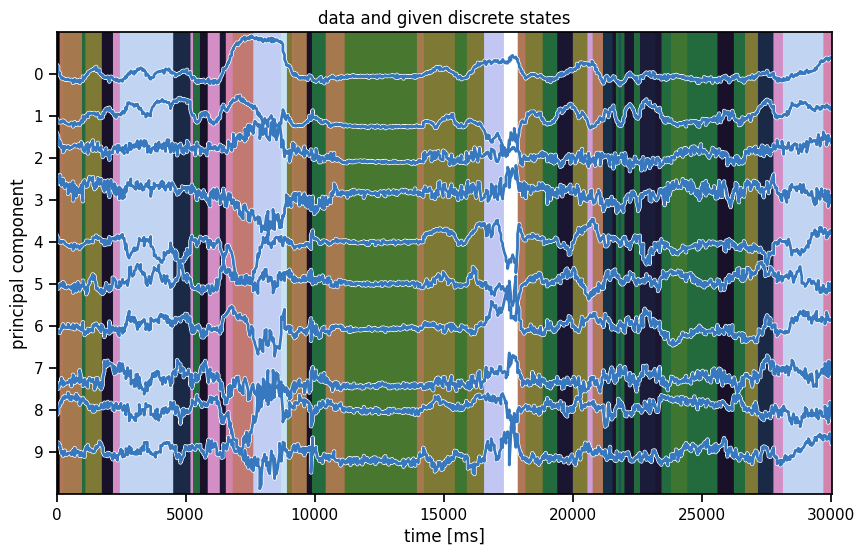

In [13]:
plot_data_and_states(train_dataset[0], train_dataset[0]["labels"],
                     title="data and given discrete states")

### Summary

You should now have a `train_dataset` and a `test_dataset` loaded in memory. Each dataset is a list of dictionaries, one for each mouse. Each dictionary contains a few keys, most important of which is the `data` key, containing the standardized principal component time series, as shown above. For the test dataset, we also included the `frames` key, which has the original 80x80 images. We'll use these to create the movies of each inferred state.

**Note:** Keeping the data in memory is costly but convenient.  You shouldn't run out of memory in this lab, but if you ever did, a better solution might be to write the preprocessed data (e.g. with the standardized PC trajectories) back to the NWB files and reload those files as necessary during fitting.

## Part 1: Implement the forward-backward algorithm

First, implement the forward-backward algorithm for computing the posterior distribution on latent states of a hidden Markov model, $q(z) = p(z \mid x, \Theta)$. Specifically, this algorithm will return a $T \times K$ matrix where each entry represents the posterior probability that $q(z_t = k)$.

### Helper functions to create random parameters

In [14]:
def sticky_transitions(
    num_states: int,
    stickiness: float = 0.95
    ) -> Float[torch.Tensor, "num_states num_states"]:
    """Creates a 'sticky' transition probability matrix.

    Diagonal elements (self-transitions) are set to `stickiness`. The
    remaining probability (1 - `stickiness`) is distributed equally among
    the other (`num_states` - 1) transitions for each row.

    Args:
        num_states: The number of states (K), determining matrix size (KxK).
        stickiness: Probability of self-transition. Defaults to 0.95.

    Returns:
        A PyTorch Tensor (shape: `num_states` x `num_states`) representing
        the sticky transition matrix, with float32 data type.
    """
    P = stickiness * torch.eye(num_states)
    P += (1 - stickiness) / (num_states - 1) * (1 - torch.eye(num_states))
    return P

def random_args(
    num_timesteps: int,
    num_states: int,
    seed: int = 0,
    offset: Number = 0,
    scale: Number = 1
    ) -> Tuple[
    Float[torch.Tensor, "num_states"],
    Float[torch.Tensor, "num_states num_states"],
    Float[torch.Tensor, "num_timesteps num_states"]
    ]:
    """Generates random HMM parameters: initial distribution, transition matrix, and log likelihoods.

    Sets the PyTorch random seed for reproducibility. It creates a uniform
    initial state distribution (`pi`), a 'sticky' transition matrix (`P`) via
    `sticky_transitions`, and log likelihoods sampled from a Normal(0,1)
    distribution, adjusted by `offset` and `scale`.

    Args:
        num_timesteps: Number of time steps (T) for log likelihoods.
        num_states: Number of hidden states (K).
        seed: Seed for PyTorch's random number generator. Defaults to 0.
        offset: Offset added to the log likelihoods. Defaults to 0.
        scale: Scale factor for the random component of log likelihoods. Defaults to 1.

    Returns:
        A tuple `(pi, P, log_likes)` containing:
        - `pi` (torch.Tensor): Uniform initial state distribution (shape: K).
        - `P` (torch.Tensor): Sticky transition probability matrix (shape: KxK).
        - `log_likes` (torch.Tensor): Simulated log likelihoods (shape: TxK).
    """
    torch.manual_seed(seed)
    pi = torch.ones(num_states) / num_states
    P = sticky_transitions(num_states)
    log_likes = offset + scale * Normal(0,1).sample((num_timesteps, num_states))
    return pi, P, log_likes

### Problem 1a: Implement the forward pass

As we derived in class, the forward pass recursively computes the _normalized_ forward messages $\tilde{\alpha}_t$ and the marginal log likelihood $\log p(x \mid \Theta) = \sum_{t} \log A_t$.

**Notes**:
- This function takes in the _log_ likelihoods, $\log \ell_{tk}$, so you'll have to exponentiate in the forward pass
- You need to be careful exponentiating though. If the log likelihoods are very negative, they'll all be essentially zero when exponentiated and you'll run into a divide-by-zero error when you compute the normalized forward message. Alternatively, if they're large positive numbers, your exponent will blow up and you'll get nan's in your calculations.
- To avoid numerical issues, subtract $\max_k (\log \ell_{tk})$ prior to exponentiating. It won't affect the normalized messages, but you will have to account for it in your computation of the marginal likelihood.


In [15]:
def forward_pass(
    initial_dist: Float[torch.Tensor, "num_states"],
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    log_likes: Float[torch.Tensor, "num_timesteps num_states"]
    ) -> Tuple[
    Float[torch.Tensor, "num_timesteps num_states"], # alphas
    Float[torch.Tensor, ""]                         # marginal_ll (scalar tensor)
    ]:
    """
    Perform the (normalized) forward pass of the HMM.

    Parameters
    ----------
    initial_dist: $\pi$, the initial state distribution. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    alphas: TxK matrix with _normalized_ forward messages $\tilde{\alpha}_{t,k}$
    marginal_ll: Scalar marginal log likelihood $\log p(x | \Theta)$
    """
    alphas = torch.zeros_like(log_likes)
    marginal_ll = 0

    ###
    # YOUR CODE BELOW
    #



    #
    ###

    return alphas, marginal_ll

Compare outputs of your function to Dynamax outputs.

In [16]:
def test_forward_pass(
        num_timesteps: int = 100,
        num_states: int = 10,
        offset: Number = 0
        ) -> None:
    """Tests the `forward_pass` HMM function.

    Compares `forward_pass` outputs (alpha messages, marginal log likelihood)
    against `ssm` library results using randomly generated HMM parameters.
    Asserts for correctness and numerical stability.

    Args:
        num_timesteps: Number of time steps for the test data.
        num_states: Number of hidden states for the test HMM.
        offset: Offset used for generating test log likelihoods.

    Returns:
        None. Raises AssertionError on test failure.
    """
    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Call your code
    alphas, ll = forward_pass(pi, P, log_likes)
    assert torch.all(torch.isfinite(alphas))
    assert torch.allclose(alphas.sum(axis=1), torch.tensor(1.0))

    # Compare to Dynamax implementation.
    from dynamax.hidden_markov_model import hmm_filter
    pi_np = from_t(pi)
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)

    post = hmm_filter(pi_np, P_np, log_likes_np)
    assert np.allclose(from_t(alphas), post.predicted_probs)
    assert np.allclose(from_t(ll), post.marginal_loglik)
    print("pass")

test_forward_pass()
test_forward_pass(num_timesteps=10000, num_states=50, offset=-1000)

AssertionError: 

### Problem 1b: Implement the backward pass

Recursively compute the backward messages $\beta_t$. Again, normalize to avoid underflow, and be careful when you exponentiate the log likelihoods. The same trick of subtracting the max before exponentiating will work here too.

In [ ]:
def backward_pass(
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    log_likes: Float[torch.Tensor, "num_timesteps num_states"]
    ) -> Float[torch.Tensor, "num_timesteps num_states"]:
    """
    Perform the (normalized) backward pass of the HMM.

    Parameters
    ----------
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    betas: TxK matrix with _normalized_ backward messages $\tilde{\beta}_{t,k}$
    """
    betas = torch.zeros_like(log_likes)

    ###
    # YOUR CODE BELOW
    ...
    #
    ###

    return betas

Compare outputs of your function to Dynamax outputs.

In [ ]:
def test_backward_pass(
    num_timesteps: int = 100,
    num_states: int = 10,
    offset: Number = 0
    ) -> None:
    """Tests the `backward_pass` HMM function.

    Compares `backward_pass` outputs (normalized beta messages) against
    `ssm.messages.backward_pass` results using randomly generated HMM
    parameters. Asserts for correctness and numerical stability.

    Args:
        num_timesteps: Number of time steps for the test data.
        num_states: Number of states for the test HMM.
        offset: Offset used for generating test log likelihoods.

    Returns:
        None. Raises AssertionError on test failure.
    """

    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Call your code
    betas = backward_pass(P, log_likes)
    assert torch.all(torch.isfinite(betas))
    assert torch.allclose(betas[:-1].sum(axis=1), torch.tensor(1.0))

    # Compare to Dynamax implementation.
    from dynamax.hidden_markov_model import hmm_backward_filter
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)
    _, backward_pred_probs  = hmm_backward_filter(P_np, log_likes_np)
    assert np.allclose(betas[:-1], backward_pred_probs[:-1])
    print("pass")

test_backward_pass()
test_backward_pass(num_timesteps=10000, num_states=50, offset=-1000)

### Problem 1c: Combine the forward and backward passes to perform the E step

Compute the posterior marginal probabilities. We call these the `expected_states` because $q(z_t = k) = \mathbb{E}_{q(z)}[\mathbb{I}[z_t = k]]$. To copmute them, combine the forward messages, backward messages, and the likelihoods, then normalize. Again, be careful when exponentiating the likelihoods.

In [ ]:
def E_step(
    initial_dist: Float[torch.Tensor, "num_states"],
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    log_likes: Float[torch.Tensor, "num_timesteps num_states"]
    ) -> Dict[str, Union[
    Float[torch.Tensor, "num_timesteps num_states"], # For "expected_states"
    Float[torch.Tensor, ""]                         # For "marginal_ll" (scalar tensor)
    ]]:
    """
    Fun the forward and backward passes and then combine to compute the
    posterior probabilities q(z_t=k).

    Parameters
    ----------
    initial_dist: $\pi$, the initial state distribution. Length K, sums to 1.
    transition_matrix: $P$, a KxK transition matrix. Rows sum to 1.
    log_likes: $\log \ell_{t,k}$, a TxK matrix of _log_ likelihoods.

    Returns
    -------
    posterior: a dictionary with the following key-value pairs:
        expected_states: a TxK matrix containing $q(z_t=k)$
        marginal_ll: the marginal log likelihood from the forward pass.
    """
    ###
    # YOUR CODE BELOW
    ...
    #
    ###

    # Package the results into a dictionary summarizing the posterior
    posterior = dict(expected_states=expected_states,
                     marginal_ll=marginal_ll)
    return posterior


Compare your outputs to Dynamax.

In [ ]:
def test_E_step(
    num_timesteps: int = 100,
    num_states: int = 10,
    offset: Number = 0
    ) -> None:
    """Tests the `E_step` HMM function.

    Compares `E_step` outputs (expected states, marginal log likelihood)
    against `ssm.messages.hmm_expected_states` results using randomly
    generated HMM parameters. Asserts for correctness.

    Args:
        num_timesteps: Number of time steps for the test data.
        num_states: Number of states for the test HMM.
        offset: Offset used for generating test log likelihoods.

    Returns:
        None. Raises AssertionError on test failure.
    """
    pi, P, log_likes = random_args(num_timesteps, num_states, offset=offset)

    # Run your code
    posterior = E_step(pi, P, log_likes)

    # Run Dynamax code
    from dynamax.hidden_markov_model import hmm_two_filter_smoother
    pi_np = from_t(pi)
    P_np = from_t(P)
    log_likes_np = from_t(log_likes)
    post = hmm_two_filter_smoother(pi_np, P_np, log_likes_np)

    assert np.allclose(posterior["expected_states"], post.smoothed_probs)
    assert np.allclose(posterior["marginal_ll"], post.marginal_loglik)
    print("pass")

test_E_step()
test_E_step(num_timesteps=10000, num_states=50, offset=-1000)

### Time it on some more realistic sizes

It should take about 4 seconds for a $T=36000$ time series with $K=50$ states. For a dataset with 24 mice, that's about 96 seconds per epoch for the E steps. (The M-steps will take about the same amount of time, so you're looking at around 1min per epoch.)

In [ ]:
pi, P, log_likes = random_args(36000, 50)
%timeit E_step(pi, P, log_likes)

### Helper function to create a random initial posterior distribution

Finally, we'll initialize the HMM with a random posterior distribution. That way our first M step will yield reasonable parameters estimates from a random weighted combination of the data.

In [ ]:
def initialize_posteriors(
    dataset: List[Dict[str, Any]],
    num_states: int,
    seed: int = 0
    ) -> List[Dict[str, Union[Float[torch.Tensor, "num_timesteps num_states"], float]]]:
    """Initializes a list of random posterior distributions for an HMM.

    For each item in the input `dataset` (where each item is a dictionary
    expected to have a 'data' key providing time series length), this function
    creates a corresponding dictionary. This dictionary contains randomly
    initialized 'expected_states' (posterior probabilities, normalized per
    time step) and a 'marginal_ll' (marginal log likelihood) set to -infinity.
    Sets the PyTorch random seed for reproducibility.

    Args:
        dataset: A list of dictionaries. Each dictionary should contain a 'data'
                 key, where `len(data['data'])` gives the number of time steps
                 for that data sequence.
        num_states: The number of hidden states (K) for the HMM.
        seed: Seed for PyTorch's random number generator. Defaults to 0.

    Returns:
        A list of dictionaries. Each dictionary has two keys:
        - 'expected_states': A 2D PyTorch Tensor (shape: T x K) of randomly
          initialized posterior probabilities (rows sum to 1). T varies per item.
        - 'marginal_ll': A float, initialized to `-torch.inf`.
    """
    torch.manual_seed(seed)
    posteriors = []
    for data in dataset:
        expected_states = torch.rand(len(data["data"]), num_states)
        expected_states /= expected_states.sum(axis=1, keepdims=True)
        posteriors.append(dict(expected_states=expected_states,
                               marginal_ll=-torch.inf))
    return posteriors

## Part 2: Gaussian HMM

First we'll implement a hidden Markov model (HMM) with Gaussian observations. This is the same model we studied in class,

$$
\begin{align}
p(x, z \mid \Theta) &= \mathrm{Cat}(z_1 \mid \pi) \prod_{t=2}^{T} \mathrm{Cat}(z_t \mid P_{z_{t-1}}) \prod_{t=1}^T \mathcal{N}(x_t \mid b_{z_t}, Q_{z_t})
\end{align}
$$

with parameters $\Theta = \pi, P, \{b_k, Q_k\}_{k=1}^K$. The observed datapoints are $x_t \in \mathbb{R}^{D}$ and the latent states are $z_t \in \{1,\ldots, K\}$.

### Problem 2a: Write a Gaussian Observations object

We'll write a `GaussianObservations` class to wrap the parameters and implement key functions for EM.

Most important, `M_step` solves for the optimal parameters given the expected sufficient statistics $\overline{T}_k, \overline{\mathbf{t}}_{k,1}, \overline{\mathbf{t}}_{k,2}$, which are passed in as a tuple. The new parameters are written to the class variables `self.means` and `self.covs`

In [ ]:
class GaussianObservations(object):
    """
    Wrapper for a collection of Gaussian observation parameters.
    """
    # Instance variable type hints
    num_states: int
    data_dim: int
    means: Float[torch.Tensor, "num_states data_dim"]
    covs: Float[torch.Tensor, "num_states data_dim data_dim"]

    def __init__(self, num_states: int, data_dim: int) -> None:
        """
        Initialize a collection of observation parameters for a Gaussian HMM
        with `num_states` (i.e. K) discrete states and `data_dim` (i.e. D)
        dimensional observations.
        """
        self.num_states = num_states
        self.data_dim = data_dim
        self.means = torch.zeros((num_states, data_dim))
        self.covs = torch.tile(torch.eye(data_dim), (num_states, 1, 1))

    @staticmethod
    def precompute_suff_stats(dataset: List[Dict[str, Any]]) -> None:
        """
        Compute the sufficient statistics of the Gaussian distribution for each
        data dictionary in the dataset. This modifies the dataset in place.

        Parameters
        ----------
        dataset: a list of data dictionaries.

        Returns
        -------
        Nothing, but the dataset is updated in place to have a new `suff_stats`
            key, which contains a tuple of sufficient statistics.
        """
        for data in dataset:
            x = data['data']
            data['suff_stats'] = (torch.ones(len(x)),                  # 1
                                  x,                                   # x_t
                                  torch.einsum('ti,tj->tij', x, x))    # x_t x_t^T

    def log_likelihoods(
        self,
        data: Dict[str, Any]
        ) -> Float[torch.Tensor, "num_timesteps num_states"]:
        """
        Compute the matrix of log likelihoods of data for each state.
        (I like to use torch.distributions for this, though it requires
         converting back and forth between numpy arrays and pytorch tensors.)

        Parameters
        ----------
        data: a dictionary with multiple keys, including "data", the TxD array
            of observations for this mouse.

        Returns
        -------
        log_likes: a TxK array of log likelihoods for each datapoint and
            discrete state.
        """
        x = data["data"]

        ###
        # YOUR CODE BELOW
        #
        log_likes = ...
        #
        ###
        return log_likes

    def M_step(
        self,
        stats: Tuple[ # This tuple structure comes from compute_expected_suff_stats
            Float[torch.Tensor, "num_states"],               # Ns (expected counts per state)
            Float[torch.Tensor, "num_states data_dim"],      # t1s (expected sum_of_x per state)
            Float[torch.Tensor, "num_states data_dim data_dim"] # t2s (expected sum_of_xxT per state)
        ]
        ) -> None:
        """
        Compute the Gaussian parameters give the expected sufficient statistics.

        Note: add a little bit (1e-4 * I) to the diagonal of each covariance
            matrix to ensure that the result is positive definite.

        Parameters
        ----------
        stats: a tuple of expected sufficient statistics

        Returns
        -------
        Nothing, but self.means and self.covs are updated in place.
        """
        Ns, t1s, t2s = stats

        ###
        # YOUR CODE BELOW
        ...
        #
        ###

In [ ]:
def test_gaussian(
    data_dim: int = 3,
    seed: int = 0
    ) -> None:
    """Tests `GaussianObservations` class methods (`log_likelihoods`, `M_step`).

    Generates synthetic Gaussian data. Asserts shapes and numerical values
    of computed log likelihoods and estimated parameters (means, covariances)
    after the M_step against expected analytical results.

    Args:
        data_dim: Dimensionality of the synthetic data. Defaults to 3.
        seed: Seed for random number generation. Defaults to 0.

    Returns:
        None. Raises AssertionError on test failure.
    """
    torch.manual_seed(0)
    data1 = Normal(0,1).sample((100, data_dim))
    data2 = Normal(0,1).sample((100, data_dim))
    data = torch.vstack([data1, data2])
    T = data.shape[0]
    num_states = 2

    obs = GaussianObservations(num_states, data_dim)
    lls = obs.log_likelihoods(dict(data=data))
    assert lls.shape == (T, num_states)
    assert torch.all(torch.isfinite(lls))

    stats = [None, None, None]
    stats[0] = 0.5 * torch.ones(2)
    stats[1] = torch.stack([data1.sum(0) / T, data2.sum(0) / T])
    stats[2] = torch.stack([data1.T @ data1 / T, data2.T @ data2 / T])

    obs.M_step(stats)
    assert torch.allclose(obs.means[0], data1.mean(axis=0))
    assert torch.allclose(obs.means[1], data2.mean(axis=0))
    assert torch.allclose(obs.covs[0], torch.cov(data1.T, correction=0) \
                        + 1e-4 * torch.eye(data_dim), atol=1e-5)
    assert torch.allclose(obs.covs[1], torch.cov(data2.T, correction=0) \
                        + 1e-4 * torch.eye(data_dim), atol=1e-5)

test_gaussian()

### Precompute the sufficient statistics

This updates the datasets in place with the sufficient statistics for a Gaussian distribution.  The statistics are placed in the `suff_stats` key.

In [ ]:
GaussianObservations.precompute_suff_stats(train_dataset)
GaussianObservations.precompute_suff_stats(test_dataset)

### Problem 2b: Write a function to compute *normalized* expected sufficient statistics

Let $M$ denote the number of mice in the dataset and let $x_t^{(m)}$ and $z_t^{(m)}$ denote their data and discrete states, respectively. Compute
- $\overline{T}_{k}$ for each of the $k$ states
- $\overline{\mathbf{t}}_{k,1} = \sum_{m=1}^M \sum_{t=1}^{T_m} q(z_{t}^{(m)} = k) \, t_1(x_t^{(m)})$ for each of the $k$ states
- $\overline{\mathbf{t}}_{k,2} = \sum_{m=1}^M \sum_{t=1}^{T_m} q(z_{t}^{(m)} = k) \, t_2(x_t^{(m)})$ for each of the $k$ states

In [ ]:
def compute_expected_suff_stats(
    dataset: List[Dict[str, Any]],
    posteriors: List[Dict[str, Any]]
    ) -> Tuple[torch.Tensor, ...]:
    """
    Compute a tuple of normalized sufficient statistics, taking a weighted sum
    of the posterior expected states and the sufficient statistics, then
    normalizing by the length of the sequence. The statistics are combined
    across all mice (i.e. all the data dictionaries and posterior dictionaries).

    Parameters
    ----------
    dataset: a list of dictionary with multiple keys, including "data", the TxD
        array of observations for this mouse, and "suff_stats", the tuple of
        sufficient statistics.

    Returns
    -------
    stats: a tuple of normalized sufficient statistics. E.g. if the
        "suff_stats" key has four arrays, the stats tuple should have four
        entires as well. Each entry should be a K x (size of statistic) array
        with the expected sufficient statistics for each of the K discrete
        states.
    """
    assert isinstance(dataset, list)
    assert isinstance(posteriors, list)

    # Helper function to compute expected counts and sufficient statistics
    # for a single time series and corresponding posterior.
    def _compute_expected_suff_stats(data, posterior):
        ###
        # YOUR CODE BELOW
        # Hint: einsum might be useful
        q = posterior['expected_states']
        stats = ...
        #
        ###

    # Sum the expected stats over the whole dataset
    combined_T = 0
    combined_stats = None
    for data, posterior in zip(dataset, posteriors):
        this_T, these_stats = _compute_expected_suff_stats(data, posterior)
        combined_T, combined_stats = combine(
            combined_T, combined_stats, this_T, these_stats)
    return combined_stats

def test_expec_suff_stats() -> None:
    """Tests the `compute_expected_suff_stats` function.

    Uses a data item from `train_dataset` (assumed globally available)
    and a randomly generated posterior distribution. Asserts the shapes
    and numerical values of the output expected sufficient statistics
    against predefined correct values for a Gaussian HMM.

    Args:
        None.

    Returns:
        None. Raises AssertionError on test failure.
    """
    torch.manual_seed(0)
    data = train_dataset[0]
    data_dim = data['data'].shape[1]
    num_states = 10

    # make a random "posterior"
    q = torch.rand(len(data['data']), num_states)
    q /= q.sum(axis=1, keepdims=True)
    posterior = dict(expected_states=q)

    # call your function
    stats = compute_expected_suff_stats([data], [posterior])

    # Check that you have the right output shape
    assert len(stats) == 3
    assert stats[0].shape == (num_states,)
    assert stats[1].shape == (num_states, data_dim)
    assert stats[2].shape == (num_states, data_dim, data_dim)

test_expec_suff_stats()

### Problem 2c: Write a function to fit an HMM with EM

In [ ]:
def fit_hmm(
    train_dataset: List[Dict[str, Any]],
    test_dataset: List[Dict[str, Any]],
    initial_dist: Float[torch.Tensor, "num_states"],
    transition_matrix: Float[torch.Tensor, "num_states num_states"],
    observations: Any,
    seed: int = 0,
    num_iters: int = 50
    ) -> Tuple[
    Float[torch.Tensor, "num_iters"],
    Float[torch.Tensor, "num_iters"],
    List[Dict[
    str,
    Union[
        Float[torch.Tensor, "num_timesteps num_states"],
        Float[torch.Tensor, ""]
        ]]],
    List[Dict[
    str,
    Union[
        Float[torch.Tensor, "num_timesteps num_states"],
        Float[torch.Tensor, ""]
        ]]]
    ]:
    """
    Fit a Hidden Markov Model (HMM) with expectation maximization (EM).

    Note: This is only a partial fit, as this method will treat the initial
    state distribution and the transition matrix as fixed!

    Parameters
    ----------
    train_dataset: a list of dictionary with multiple keys, including "data",
        the TxD array of observations for this mouse, and "suff_stats", the
        tuple of sufficient statistics.

    test_dataset: as above but only used for tracking the test log likelihood
        during training.

    initial_dist: a length-K vector giving the initial state distribution.

    transition_matrix: a K x K matrix whose rows sum to 1.

    observations: an Observations object with `log_likelihoods` and `M_step`
        functions.

    seed: random seed for initializing the algorithm.

    num_iters: number of EM iterations.

    Returns
    -------
    train_lls: array of likelihoods of training data over EM iterations
    test_lls: array of likelihoods of testing data over EM iterations
    posteriors: final list of posterior distributions for the training data
    test_posteriors: final list of posterior distributions for the test data
    """
    # Get some constants
    num_states = observations.num_states
    num_train = sum([len(data["data"]) for data in train_dataset])
    num_test = sum([len(data["data"]) for data in test_dataset])

    # Check the initial distribution and transition matrix
    assert initial_dist.shape  == (num_states,) and \
        torch.all(initial_dist >= 0) and \
        torch.isclose(initial_dist.sum(), torch.tensor(1.0))
    assert transition_matrix.shape  == (num_states, num_states) and \
        torch.all(transition_matrix >= 0) and \
        torch.allclose(transition_matrix.sum(axis=1), torch.tensor(1.0))

    # Initialize with a random posterior
    posteriors = initialize_posteriors(train_dataset, num_states, seed=seed)
    stats = compute_expected_suff_stats(train_dataset, posteriors)

    # Track the marginal log likelihood of the train and test data
    train_lls = []
    test_lls = []

    # Main loop
    for itr in trange(num_iters):
        ###
        # YOUR CODE BELOW
        #

        # M step: update the parameters of the observations using the
        #         expected sufficient stats.
        ...

        # E step: computhe the posterior for each data dictionary in the dataset
        posteriors = ...

        # Compute the expected sufficient statistics under the new posteriors
        stats = ...

        # Store the average train likelihood
        avg_train_ll = sum([p["marginal_ll"] for p in posteriors]) / num_train
        train_lls.append(avg_train_ll)

        # Compute the posteriors for the test dataset too
        test_posteriors = ...

        # Store the average test likelihood
        avg_test_ll = sum([p["marginal_ll"] for p in test_posteriors]) / num_test
        test_lls.append(avg_test_ll)

        #
        ###

    # convert lls to arrays
    train_lls = torch.stack(train_lls)
    test_lls = torch.stack(test_lls)
    return train_lls, test_lls, posteriors, test_posteriors


### Fit it! (Just to one mouse for now...)

We'll just use the first mouse's data for now.

In [ ]:
# Build the HMM
num_states = 50
initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)
observations = GaussianObservations(num_states, data_dim)

# Fit the HMM with EM
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit_hmm(train_dataset[:1],
            test_dataset[:1],
            initial_dist,
            transition_matrix,
            observations)

plt.plot(train_lls, label="train")
plt.plot(test_lls, '-r', label="test")
plt.xlabel("iteration")
plt.ylabel("avg marginal log lkhd")
plt.grid(True)
plt.legend()

### Plot the data and the inferred latent states

We'll make the same plot as above (in the warm-up) but using our inferred states instead. Hopefully, the states seem to switch along with changes in the data.

**Note**: We're showing the state with the highest marginal probability, $z_t^\star = \mathrm{arg} \, \mathrm{max}_k \; q(z_t = k)$. This is different from the most likely state path, $z_{1:T}^\star = \mathrm{arg}\,\mathrm{max} \; q(z)$. We could compute the latter with the Viterbi algorithm, which is similar to the forward-backward algorithm you implemented above.

In [ ]:
ghmm_states = train_posteriors[0]["expected_states"].argmax(1)
plot_data_and_states(train_dataset[0], ghmm_states)

### Plot the state usage histogram

The state usage histogram shows how often each discrete state was used under the posterior distribution. You'll probably see a long tail of states with non-trivial usage (hundreds of frames), all the way out to state 50. That suggests the model is using all its available capacity, and we could probably crank the number of states up even further for this model.

In [ ]:
# Sort states by usage
ghmm_usage = torch.bincount(ghmm_states, minlength=num_states)
ghmm_order = torch.argsort(ghmm_usage, descending=True)

plt.bar(torch.arange(num_states), ghmm_usage[ghmm_order])
plt.xlabel("state index [ordered]")
plt.ylabel("num frames")
plt.title("histogram of inferred state usage")

### Make average PC plots for each state

In [ ]:
plot_average_pcs(ghmm_order[3], train_dataset, train_posteriors)

### Make "crowd" movies

In [ ]:
play(make_crowd_movie(ghmm_order[0], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(ghmm_order[1], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(ghmm_order[2], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(ghmm_order[3], test_dataset, test_posteriors))

### Download crowd movies for each state

I've commented this out because it takes about ten minutes, but this will allow you to download and view the crowd movies for all states.

In [ ]:
# # Make "crowd" movies for each state and save them to disk
# # Then you can download them and play them offline
# for i in trange(num_states):
#     try:
#         play(make_crowd_movie(order[i], test_dataset, test_posteriors),
#             filename="gaussian_hmm_crowd_{}.mp4".format(i), show=False)
#     except:
#         print("failed to create a movie for state", order[i])

# # Zip the movies up
# !zip gaussian_crowd_movies.zip gaussian_hmm_crowd_*.mp4

# # Download the file
# files.download("gaussian_crowd_movies.zip")

### Problem 2d [Short Answer]: Hyperparameter selection

The results above give some qualitative reason to believe the model is "working" reasonably. However, there are a few knobs that we had to set. What are they? How could you try to set them in a more principled manner? Is there even a "right" setting of them?

_Answer below this line_

---

## Part 3: Autoregressive HMMs

Autoregressive hidden Markov models (ARHMMs) replace the Gaussian observations with an AR model:

$$
\begin{align}
p(x, z \mid \Theta) &= \mathrm{Cat}(z_1 \mid \pi) \prod_{t=2}^{T} \mathrm{Cat}(z_t \mid P_{z_{t-1}}) \prod_{t=1}^T p(x_t \mid x_{1:t-1}, z_t)
\end{align}
$$

The model is "autoregressive" because $x_t$ depends not only on $z_t$ but on $x_{1:t-1}$ as well. The precise form of this dependence varies; here we will consider linear Gaussian dependencies on only the most recent $G$ timesteps,:

$$
\begin{align}
p(x_t \mid x_{1:t-1}, z_t) &= \mathcal{N}\left(\sum_{g=1}^G A_{z_t,g} x_{t-g} + b_{z_t,g}, Q_{z_t} \right)  
\end{align}
$$

The new parameters are $\Theta = \pi, P, \{\{A_{k,g}, b_{k,g}\}_{g=1}^G, Q_k\}_{k=1}^K$, which include weights $A_{k,g} \in \mathbb{R}^{D \times D}$ for each of the $K$ states and the $G$ lags, and a bias vector $b_k \in \mathbb{R}^D$.

Note that we can write this as a simple **linear regression**,

$$
\begin{align}
p(x_t \mid x_{1:t-1}, z_t) &= \mathcal{N}\left(W_k \phi_t , Q_{z_t} \right)  
\end{align}
$$

where $\phi_t = (x_{t-1}, \ldots, x_{t-G}, 1) \in \mathbb{R}^{GD +1}$ is a vector of covariates (aka features) that includes the past $G$ time steps along with a 1 for the bias term.

$$
\begin{align}
W_k = \begin{bmatrix} A_{k,1}  & A_{k,2} & \ldots & A_{kg} & b_k \end{bmatrix}
\in \mathbb{R}^{D \times GD + 1}
\end{align}
$$

is a block matrix of the autoregressive weights and the bias.

_Note that the covariates are fixed functions of the data so we can precompute them, if we know the number of lags $G$._

### Problem 3a [Math]: Derive the natural parameters and sufficient statistics for a linear regression

Expand the the ELBO in terms of $W_k$ and $b_k$,

$$
\begin{align}
\mathcal{L}(q, \theta) \triangleq \mathbb{E}_{q(z)}\left[ \sum_{t=1}^T \mathbb{I}[z_t=k] \cdot \log \mathcal{N}(x_t \mid W_k \phi_t, Q_k) \right] + c.
\end{align}
$$

Write it as a sum of inner products between natural parameters (i.e. functions of $W_k$ and $Q_k$) and expected sufficient statistics $\overline{T}_k$, $\bar{\mathbf{t}}_{k,1}$, $\bar{\mathbf{t}}_{k,2}$, $\bar{\mathbf{t}}_{k,3}$ (i.e. functions of $q$, $x$ and $\phi$).

**Hint**: The form should look similar to that of the Gaussian distribution we derived in class, except that now we have a three sufficient statistics and they depend on both $x$ and $\phi$.

_Answer below this line_

---

### Problem 3b [Math]: Solve for the optimal linear regression parameters given expected sufficient statistics

Solve for $W_k^\star, Q_k^\star$ that maximize the objective above in terms of the expected sufficient statistics $T_k$, $\bar{\mathbf{t}}_{k,1}$, $\bar{\mathbf{t}}_{k,2}$, $\bar{\mathbf{t}}_{k,3}$.

_Answer below this line_

---

### Problem 3c: Implement an Linear Regression Observations object

In [ ]:
class LinearRegressionObservations(object):
    """
    Wrapper for a collection of Gaussian observation parameters.
    """
    num_states: int      # K
    data_dim: int        # D (dimension of observed data y_t)
    covariate_dim: int   # M (dimension of covariates phi_t)

    weights: Float[torch.Tensor, "num_states data_dim covariate_dim"]       # W_k (K, D, M)
    covs: Float[torch.Tensor, "num_states data_dim data_dim"]               # Q_k (K, D, D)

    def __init__(self, num_states: int, data_dim: int, covariate_dim: int) -> None:
        """
        Initialize a collection of observation parameters for an HMM whose
        observation distributions are linear regressions. The HMM has
        `num_states` (i.e. K) discrete states, `data_dim` (i.e. D)
        dimensional observations, and `covariate_dim` covariates.
        In an ARHMM, the covariates will be functions of the past data.
        """
        self.num_states = num_states
        self.data_dim = data_dim
        self.covariate_dim = covariate_dim

        # Initialize the model parameters
        self.weights = torch.zeros((num_states, data_dim, covariate_dim))
        self.covs = torch.tile(torch.eye(data_dim), (num_states, 1, 1))

    @staticmethod
    def precompute_suff_stats(dataset: List[Dict[str, Any]]) -> None:
        """
        Compute the sufficient statistics of the linear regression for each
        data dictionary in the dataset. This modifies the dataset in place.

        Parameters
        ----------
        dataset: a list of data dictionaries.

        Returns
        -------
        Nothing, but the dataset is updated in place to have a new `suff_stats`
            key, which contains a tuple of sufficient statistics.
        """
        ###
        # YOUR CODE BELOW
        #
        ...
        #
        ###

    def log_likelihoods(
            self,
            data: Dict[str, Any]
            ) -> Float[torch.Tensor, "num_timesteps num_states"]:
        """
        Compute the matrix of log likelihoods of data for each state.
        (I like to use torch.distributions for this, though it requires
         converting back and forth between numpy arrays and pytorch tensors.)

        Parameters
        ----------
        data: a dictionary with multiple keys, including "data", the TxD array
            of observations for this mouse.

        Returns
        -------
        log_likes: a TxK array of log likelihoods for each datapoint and
            discrete state.
        """
        ###
        # YOUR CODE BELOW
        #
        log_likes = ...
        #
        ###
        return log_likes

    def M_step(
        self,
        stats: Tuple[
            Float[torch.Tensor, "num_states"],
            Float[torch.Tensor, "num_states data_dim data_dim"],
            Float[torch.Tensor, "num_states data_dim covariate_dim"],
            Float[torch.Tensor, "num_states covariate_dim covariate_dim"]
        ]
    ) -> None:
        """
        Compute the linear regression parameters given the expected
        sufficient statistics.

        Note: add a little bit (1e-4 * I) to the diagonal of each covariance
            matrix to ensure that the result is positive definite.


        Parameters
        ----------
        stats: a tuple of expected sufficient statistics

        Returns
        -------
        Nothing, but self.weights and self.covs are updated in place.
        """
        Ns, t1s, t2s, t3s = stats
        ###
        # YOUR CODE BELOW
        ...
        #
        ###

### Problem 3d: Precompute the covariates for an autoregressive model

In [ ]:
def precompute_ar_covariates(
    dataset: List[Dict[str, Any]],
    num_lags: int = 2,
    fit_intercept: bool = True
    ) -> None:
    """Precomputes autoregressive (AR) covariates for time series data.

    For each data item in `dataset` (which must contain a 'data' key mapping
    to a TxD_in tensor), this function generates AR features. These include
    `num_lags` lagged versions of the 'data' tensor (zero-padded at the start)
    and optionally an intercept term. The resulting covariate matrix is added
    to each data item's dictionary under the key 'covariates' (in-place).

    Args:
        dataset: A list of dictionaries. Each dictionary is expected to have
                 a 'data' key with a 2D PyTorch Tensor (time_steps x features).
                 These dictionaries are modified in-place.
        num_lags: Number of past time steps to include as covariates.
                  Defaults to 2.
        fit_intercept: If True, adds a constant intercept term (a column of
                       ones) to the covariates. Defaults to True.

    Returns:
        None. The `dataset` dictionaries are modified directly.
    """
    for data in dataset:
        x = data["data"]
        data_dim = x.shape[1]

        ###
        # YOUR CODE BELOW
        data["covariates"] = ...
        #
        ###

### Precompute the AR features and the sufficient statistics

We'll store them in memory for convenience, even though it's redundant and memory intensive.

**Note: avoid running this cell multiple times as it will cause you to run out of memory and crash the notebook.**

In [ ]:
num_lags = 2
precompute_ar_covariates(train_dataset, num_lags=2)
precompute_ar_covariates(test_dataset, num_lags=2)
LinearRegressionObservations.precompute_suff_stats(train_dataset)
LinearRegressionObservations.precompute_suff_stats(test_dataset)

### Fit it!

This should take about 10 minutes

In [ ]:
# Build the HMM
num_states = 50
initial_dist = torch.ones(num_states) / num_states
transition_matrix = sticky_transitions(num_states, stickiness=0.95)
observations = LinearRegressionObservations(num_states, data_dim,
                                            num_lags * data_dim + 1)

# Fit it!
train_lls, test_lls, train_posteriors, test_posteriors, = \
    fit_hmm(train_dataset[:1],
            test_dataset[:1],
            initial_dist,
            transition_matrix,
            observations)

plt.plot(train_lls, label="train")
plt.plot(test_lls, '-r', label="test")
plt.xlabel("iteration")
plt.ylabel("avg marginal log lkhd")
plt.grid(True)
plt.legend()

### Plot the data and the inferred states


We'll make the same plot as above (in the warm-up) but using our inferred states instead. Hopefully, the states seem to switch along with changes in the data.

**Note**: We're showing the state with the highest marginal probability, $z_t^\star = \mathrm{arg} \, \mathrm{max}_k \; q(z_t = k)$. This is different from the most likely state path, $z_{1:T}^\star = \mathrm{arg}\,\mathrm{max} \; q(z)$. We could compute the latter with the Viterbi algorithm, which is similar to the forward-backward algorithm you implemented above.

In [ ]:
arhmm_states = train_posteriors[0]["expected_states"].argmax(1)
plot_data_and_states(train_dataset[0], arhmm_states)

### Plot the state usage histogram


The state usage histogram shows how often each discrete state was used under the posterior distribution. You'll probably see a long tail of states with non-trivial usage (hundreds of frames), all the way out to state 50. That suggests the model is using all its available capacity, and we could probably crank the number of states up even further for this model.

In [ ]:
# Sort states by usage
arhmm_states = train_posteriors[0]["expected_states"].argmax(1)
arhmm_usage = torch.bincount(arhmm_states, minlength=num_states)
arhmm_order = torch.argsort(arhmm_usage, descending=True)

plt.bar(torch.arange(num_states), arhmm_usage[arhmm_order])
plt.xlabel("state index [ordered]")
plt.ylabel("num frames")
plt.title("histogram of inferred state usage")

### Plot the average PC trajectory time locked to state entry

In [ ]:
plot_average_pcs(arhmm_order[34], train_dataset[:1], train_posteriors[:1])

### Plot some "crowd" movies

In [ ]:
play(make_crowd_movie(arhmm_order[0], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(arhmm_order[1], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(arhmm_order[2], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(arhmm_order[3], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(arhmm_order[4], test_dataset, test_posteriors))

In [ ]:
play(make_crowd_movie(arhmm_order[20], test_dataset, test_posteriors))

### Download crowd movies for each state

I've commented this out because it takes about ten minutes. Please do it once though!

In [ ]:
# # Make "crowd" movies for each state and save them to disk
# # Then you can download them and play them offline
# for i in trange(num_states):
#     play(make_crowd_movie(arhmm_order[i], test_dataset, test_posteriors),
#          filename="arhmm_crowd_{}.mp4".format(i), show=False)

# # Zip the movies up
# !zip arhmm_crowd_movies.zip arhmm_crowd_*.mp4

# from google.colab import files
# files.download("arhmm_crowd_movies.zip")

## Author contributions

Write a short paragraph describing how each team member contributed to this assignment.

_Your answer here_

## Submission Instructions


Download your notebook in .ipynb format and use the following command to convert it to PDF
```
jupyter nbconvert --to pdf lab6_name.ipynb
```
If you're using Anaconda for package management, you can install `nbconvert` with
```
conda install -c anaconda nbconvert
```
Upload your .pdf file to Gradescope.

**Only one submission per team!**